<a href="https://colab.research.google.com/github/okcza515/TextPokerGame/blob/main/TextPokerGame.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from IPython.display import Image, display
from itertools import combinations
import os
import random

class PokerGame:
    CARD_IMAGES_PATH = "/content/drive/MyDrive/TextPokerGame/Card_PNG"

    def __init__(self, players):
        self.players = players
        self.deck = self.generate_deck()
        self.community_cards = []
        self.pot = 0
        self.numberFold = 0


    def generate_deck(self):
        suits = ['Hearts', 'Diamonds', 'Clubs', 'Spades']
        ranks = ['2', '3', '4', '5', '6', '7', '8', '9', '10', 'J', 'Q', 'K', 'A']
        deck = [{'rank': rank, 'suit': suit} for suit in suits for rank in ranks]
        random.shuffle(deck)
        return deck

    def load_card_image(self, card, size=(50, 75)):
        rank = card['rank']
        suit = card['suit'][0]  # Get the first letter of the suit

        # Example: Construct the file name for the image (e.g., '10C.png', 'AH.png')
        image_name = f"{rank.upper()}{suit.upper()}.png"
        image_path = os.path.join(self.CARD_IMAGES_PATH, image_name)

        # Display the resized image in Colab
        try:
            display(Image(filename=image_path, width=size[0], height=size[1]))
        except FileNotFoundError:
            print(f"Image not found for {rank} of {card['suit']}")

    def deal_community_card(self):
        community_card = self.deck.pop()
        self.community_cards.append(community_card)
        self.load_card_image(community_card)

    def deal_cards(self):
        for player in self.players:
            player.hand = [self.deck.pop(), self.deck.pop()]

    def display_hand(self, player):
        print(f"\n{player.name}'s hand:")
        for card in player.hand:
            self.load_card_image(card)

    def display_community_cards(self):
        print("\nCommunity Cards:")
        for card in self.community_cards:
            self.load_card_image(card)

    def get_user_bet(self, player):
        while True:
            try:
                bet = int(input(f"{player.name}, enter your bet: \n"))
                if bet >= 0 and bet <= player.chips:
                    return bet
                else:
                    print("Invalid bet. Please enter a valid amount.\n")
            except ValueError:
                print("Invalid input. Please enter a number.\n")

    def player_turn(self, player):
        print(f"\n{player.name}'s turn:")
        self.display_hand(player)

        # Add logic for player actions (e.g., bet, fold, etc.)
        # For simplicity, let's assume players can only bet or fold.

        if player.hasFold == 1:
          pass
        else:
            action = input("Do you want to (B)et or (F)old? \n").upper()
            if action == 'B':
              bet = self.get_user_bet(player)
              player.chips -= bet
              self.pot += bet
            elif action == 'F':
              # Player folds, implement fold logic if needed
              player.hasFold = 1
              self.numberFold +=1
              pass
            else:
              print("Invalid action. Please enter 'B' to bet or 'F' to fold.\n")

    def evaluate_winner(self):
        each_player_all_cards_list = [(player, player.hand + self.community_cards) for player in self.players]

        # Evaluate each player's hand
        player_hand_strengths = [(player, self.evaluate_hand(cards)) for player, cards in each_player_all_cards_list]

        # Find the player with the strongest hand
        winner = max(player_hand_strengths, key=lambda x: self.hand_strength_to_value(x[1]))

        print(f"\nWinner: {winner[0].name} with a {winner[1]}")
        pass

    def play_round(self):
        self.deal_cards()
        for i in range(5):  # Deal 5 community cards
            print("\n=======================================\n Round: ", i+1)
            flag = False
            for player in self.players:
                self.player_turn(player)
                if self.numberFold == len(players) - 1:
                  flag = True
                  break
            if flag:
              break
            else:
              self.deal_community_card()
              self.display_community_cards()

        # Show all cards
        print("\n=======================================\nShowdown:")
        self.display_community_cards()
        for player in self.players:
            self.display_hand(player)

        self.evaluate_winner()

    def suit(card)
      return card[-1]

    def rank(card):
        if card[0] == 'A':
          return 14
        if card[0] == 'J':
          return 11
        if card[0] == 'Q':
          return 12
        if card[0] == 'K':
          return 13
        return int(card[0:-1])


    def pair_count(self, player_all_cards):
      all_combinations = list(combinations(player_all_cards,len(player_all_cards) if len(player_all_cards)<5 else 5))
      number_of_pair = 0
      for cards in all_combinations:
        pair_combination = list(combinations(cards,2))
        count_pair = 0
        for pair in pair_combination:
           if(self.rank(pair[0]) == self.rank(pair[1])):
              count_pair +=1
        if number_of_pair<count_pair:
          number_of_pair = count_pair
      return number_of_pair

    def is_one_pair(self, player_all_cards)
      return True if self.pair_count(player_all_cards) == 1 else False

    def is_two_pair(self, player_all_cards)
      return True if self.pair_count(player_all_cards) == 2 else False

    def is_three_of_kind(self, player_all_cards):
      if len(player_all_cards)< 3: return False
      return True if self.pair_count(player_all_cards) == 3 else False ##Let's say 3 cards of best 5 is same rank, picking pair would be C3_2 =3

    def is_four_of_kind(self, player_all_cards):
      if len(player_all_cards)< 4: return False
      return True if self.pair_count(player_all_cards) == 6 else False ##Let's say 4 cards of best 5 is same rank, picking pair would be C4_2 =6


    def is_triplet(self, player_all_cards):
      if len(player_all_cards)< 5: return False
      all_combinations = list(combinations(player_all_cards, 5))
      for cards in all_combinations:
        pair_combination = list(combinations(cards,3))
        for three_cards in pair_combination:
           if(self.rank(three_cards[0]) == self.rank(three_cards[1]) == self.rank(three_cards[2])):
              return True

    def is_straight(self, player_all_cards):
      if len(player_all_cards)< 5: return False
      all_combinations = list(combinations(player_all_cards, 5))
      for cards in all_combinations:
        sorted_cards = cards.sort(key = self.rank)
        if(self.rank(sorted_cards[0]) == self.rank(sorted_cards[1])-1 == self.rank(sorted_cards[2])-2 == self.rank(sorted_cards[3])-3 == self.rank(sorted_cards[4])-4):
            return True

    def is_flush(self,player_all_cards):
      if len(player_all_cards)< 5: return False
      all_combinations = list(combinations(player_all_cards,len(player_all_cards) if len(player_all_cards)<5 else 5))
      for cards in all_combinations:
         if(all(self.suit[card]== self.suit(cards[0]) for card in cards[1:-1])):
            return True
      return False

    def is_full_house(self,player_all_cards):
      if len(player_all_cards)< 5: return False

      return True if self.pair_count(player_all_cards) == 4 else False


In [11]:
if(True):
  print("adasd")

adasd


In [ ]:
class Player:
    def __init__(self, name, chips=1000):
        self.name = name
        self.hand = []
        self.hasFold = 0
        self.chips = chips


 Round:  1

Player 1's turn:

Player 1's hand:


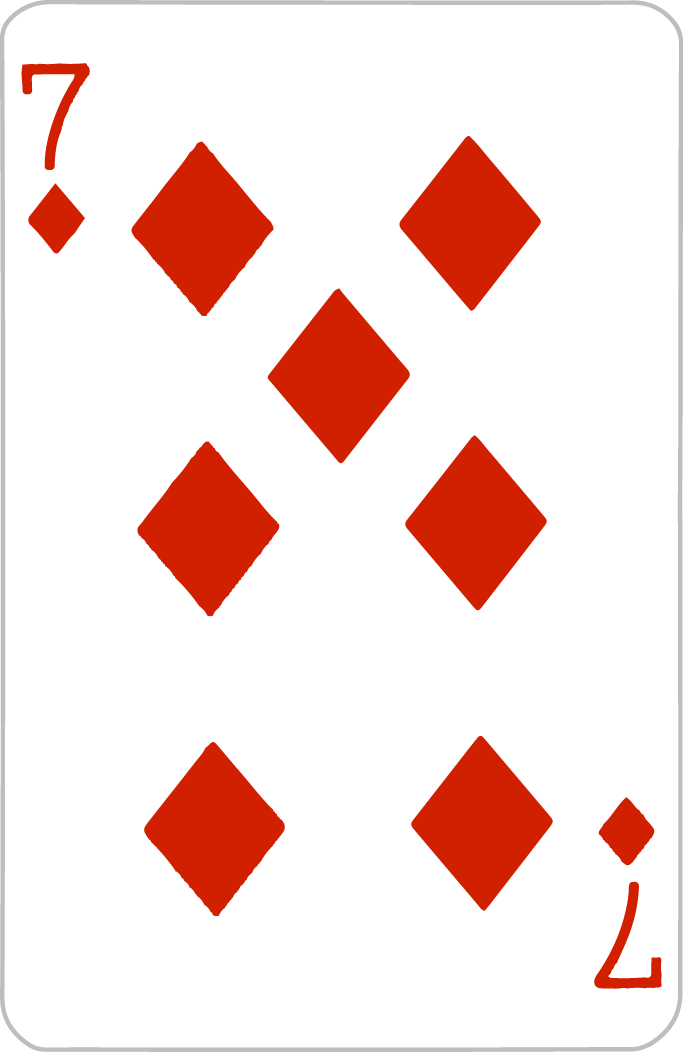

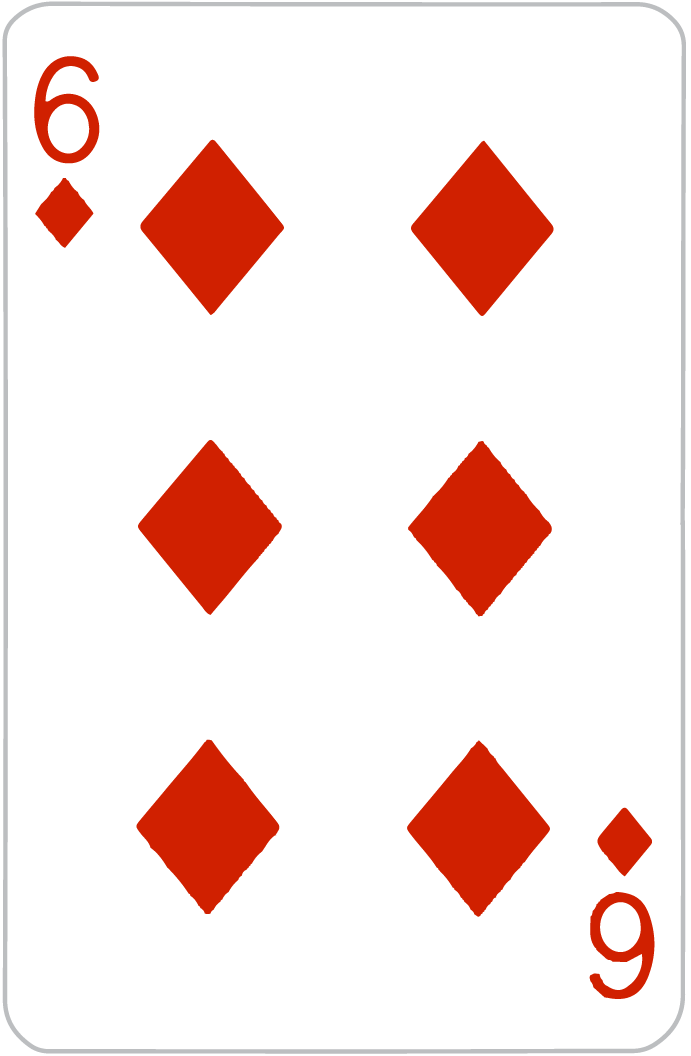

Do you want to (B)et or (F)old? 
F

Showdown:

Community Cards:

Player 1's hand:


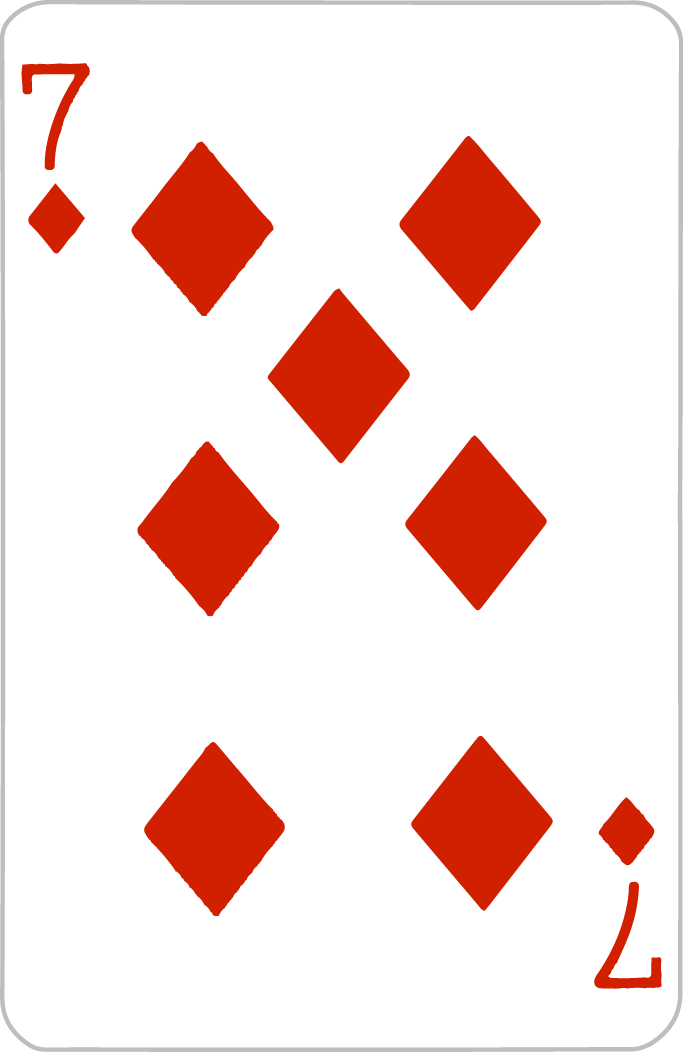

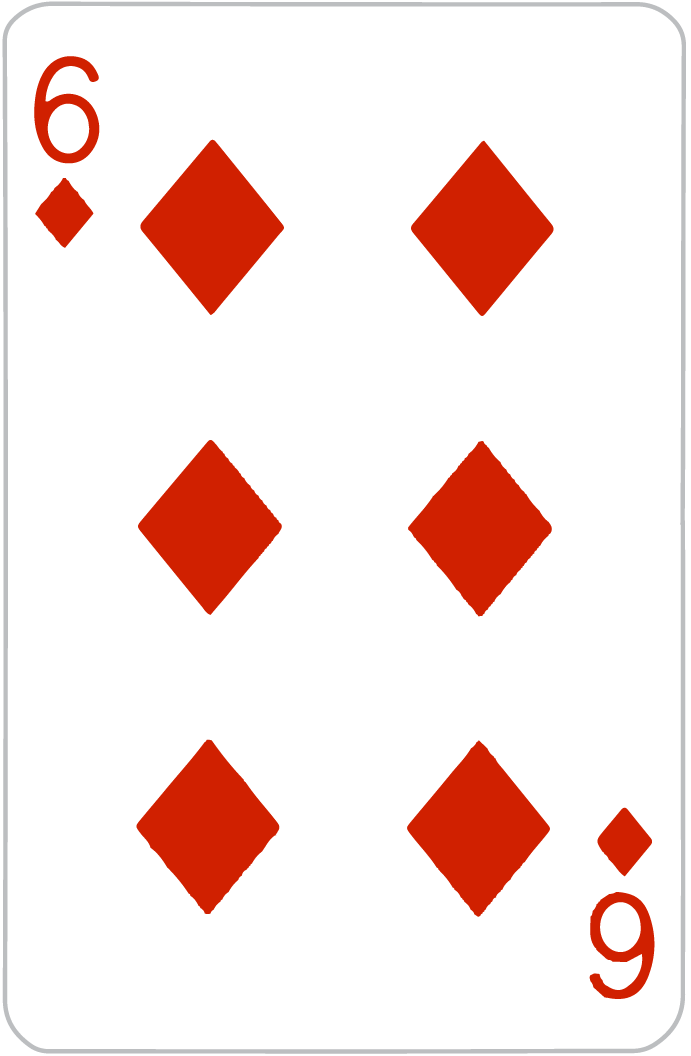


AI Bot's hand:


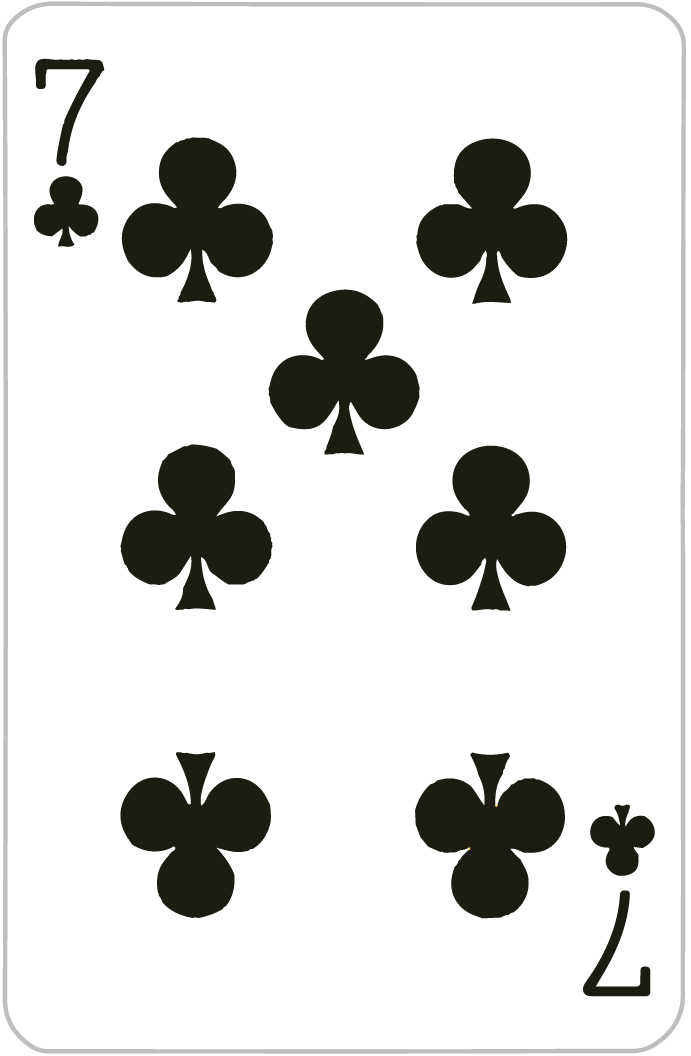

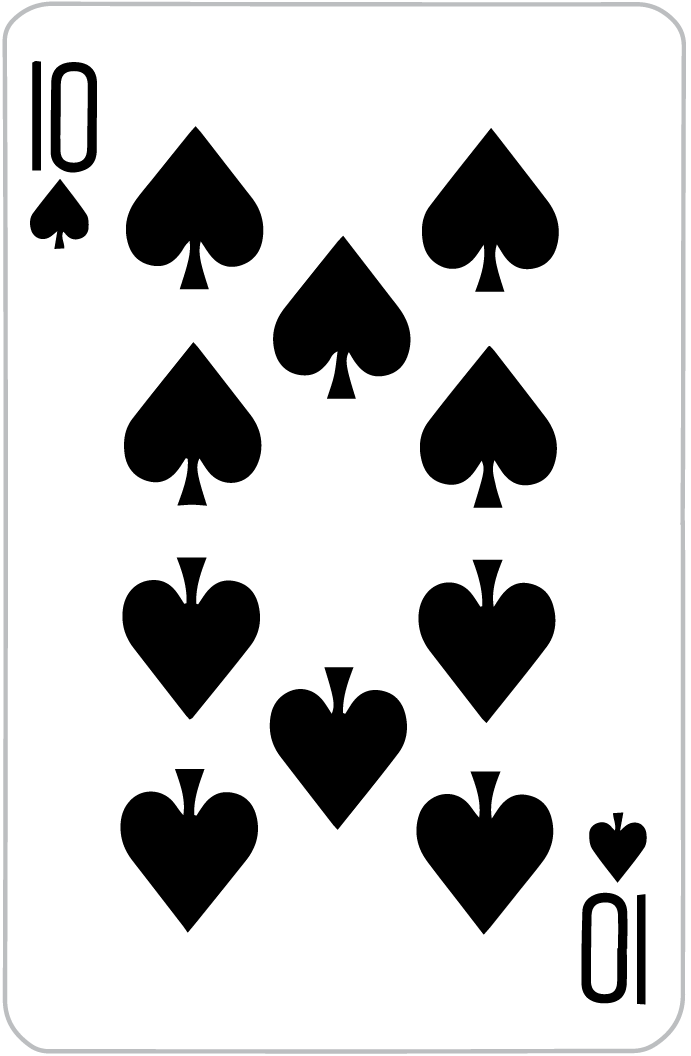

TypeError: ignored

In [ ]:
# Example usage
player1 = Player("Player 1")
player2 = Player("AI Bot")
players = [player1, player2]

game = PokerGame(players)
game.play_round()
